In [112]:
import os
import sys
import copy
import math
import multiprocessing as mul
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from tqdm.auto import tqdm

# pyLIMA
from pyLIMA import event, telescopes
from pyLIMA.toolbox import time_series
from pyLIMA.simulations import simulator
from pyLIMA.models import PSBL_model, USBL_model, FSPLarge_model, PSPL_model
from pyLIMA.fits import TRF_fit, DE_fit, MCMC_fit
from pyLIMA.outputs import pyLIMA_plots, file_outputs

# Astropy
import astropy.units as u
from astropy import constants as const
from astropy.table import QTable
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.constants import c, L_sun, sigma_sb, M_jup, M_earth, G

# Custom imports
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append('/home/anibal-pc/roman_rubin/' + '/photutils/')
from functions_roman_rubin import (
    filter_band, mag, filter5points, deviation_from_constant,
    read_data, save, tel_roman_rubin, set_photometric_parameters
)
from bandpass import Bandpass
from signaltonoise import calc_mag_error_m5
from photometric_parameters import PhotometricParameters


In [113]:
current_path = os.path.dirname(os.getcwd())
model='USBL'
path_save_sim= current_path+'/test_sim_fit/'
path_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16, 'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}
current_path = os.path.dirname(os.getcwd())



separation_0 (float, the binary separation at t0_om)

r_s (float, the ratio of the radial separation s_z over the projected separation)

s_0

a_s (float, the ratio of the microlesing separation over the true (unscaled))axis (semi-major)

v_para (float, the rotation speed along the s_0 axis, i.e. 1/s ds/dt)

v_perp (float, the rotation speed perpendicular to s_0 axis, i.e. dalpha/dt)

v_radial (float, the rotation speed in the z axis, i.e. 1/s ds_z/dt)

In [114]:
def sim_event(i, data, path_ephemerides, path_dataslice, model):
    '''
    i (int): index of the TRILEGAL data set
    data (dictionary): parameters including magnitude of the stars
    path_ephemerides (str): path to the ephemeris of Gaia
    path_dataslice(str): path to the dataslice obtained from OpSims
    model(str): model desired
    '''
    magstar = {'W149': data["W149"], 'u': data["u"], 'g': data["g"], 'r': data["r"],
               'i': data["i"], 'z': data["z"], 'y': data["Y"]}
    ZP = {'W149': 27.615, 'u': 27.03, 'g': 28.38, 'r': 28.16,
          'i': 27.85, 'z': 27.46, 'y': 26.68}
    my_own_creation, dataSlice, LSST_BandPass = tel_roman_rubin(path_ephemerides,
                                                                path_dataslice)
    photParams = set_photometric_parameters(15, 2)
    new_creation = copy.deepcopy(my_own_creation)
    np.random.seed(i)
    t0 = data['t0']
    tE = data['te']

    params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'], 'rho': data['rho'],
              's': data['s'], 'q': data['q'], 'alpha': data['alpha'],
              'piEN': data['piEN'], 'piEE': data['piEE'], 'v_para': data['v_para'], 'v_perp': data['v_perp'], 'v_radial': data['v_radial'],
             'r_s': data['r_s'], 'a_s': data['a_s']}
    # choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
    # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
    my_own_model = USBL_model.USBLmodel(new_creation,
                                        blend_flux_parameter='ftotal',
                                        parallax=['Full',t0], orbital_motion=['Keplerian', t0])
    print(my_own_model.origin)

    my_own_parameters = []
    for key in params:
        my_own_parameters.append(params[key])

    my_own_flux_parameters = []
    fs, G, F = {}, {}, {}
    np.random.seed(i)
    for band in magstar:
        flux_baseline = 10 ** ((ZP[band] - magstar[band]) / 2.5)
        g = np.random.uniform(0, 1)
        f_source = flux_baseline / (1 + g)
        fs[band] = f_source
        G[band] = g
        F[band] = f_source + g * f_source  # flux_baseline
        f_total = f_source * (1 + g)
        if my_own_model.blend_flux_parameter == "ftotal":
            my_own_flux_parameters.append(f_source)
            my_own_flux_parameters.append(f_total)
        else:
            my_own_flux_parameters.append(f_source)
            my_own_flux_parameters.append(f_source * g)

    my_own_parameters += my_own_flux_parameters
    pyLIMA_parameters = my_own_model.compute_pyLIMA_parameters(my_own_parameters)
    simulator.simulate_lightcurve_flux(my_own_model, pyLIMA_parameters)

    for k in range(1, len(new_creation.telescopes)):
        model_flux = my_own_model.compute_the_microlensing_model(new_creation.telescopes[k],
                                                                 pyLIMA_parameters)['photometry']
        new_creation.telescopes[k].lightcurve_flux['flux'] = model_flux
    Roman_band = False
    Rubin_band = False
    for telo in new_creation.telescopes:
        if telo.name == 'W149':
            x = telo.lightcurve_magnitude['time'].value
            y = telo.lightcurve_magnitude['mag'].value
            z = telo.lightcurve_magnitude['err_mag'].value
            m5 = np.ones(len(x)) * 27.6
            X, Y, Z, sigma_5 = filter_band(x, y - 27.4 + ZP[telo.name], z, m5, telo.name)
            telo.lightcurve_magnitude = QTable([X, Y, Z],
                                               names=['time', 'mag', 'err_mag'], units=['JD', 'mag', 'mag'])
            if not len(telo.lightcurve_magnitude['mag']) == 0:
                Roman_band = True
        else:
            X = telo.lightcurve_flux['time'].value
            ym = mag(ZP[telo.name], telo.lightcurve_flux['flux'].value)
            z, y, x, M5 = [], [], [], []
            for k in range(len(ym)):
                m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == telo.name)][k]
                magerr = calc_mag_error_m5(ym[k], LSST_BandPass[telo.name], m5, photParams)[0]
                z.append(magerr)
                y.append(np.random.normal(ym[k], magerr))
                x.append(X[k])
                M5.append(m5)
            X, Y, Z, sigma_5 = filter_band(x, y, z, M5, telo.name)
            telo.lightcurve_magnitude = QTable([X, Y, Z],
                                               names=['time', 'mag', 'err_mag'],
                                               units=['JD', 'mag', 'mag'])

            if not len(telo.lightcurve_magnitude['mag']) == 0:
                Rubin_band = True

    # This first if holds for an event with at least one Roman and Rubin band
    if Rubin_band and Roman_band:
        # This second if holds for a "detectable" event to fit
        if filter5points(pyLIMA_parameters, new_creation.telescopes) and deviation_from_constant(pyLIMA_parameters, new_creation.telescopes):
            print("A good event to fit")
            return my_own_model, pyLIMA_parameters, True
        else:
            print(
                "Not a good event to fit.\nFail 5 points in t0+-tE\nNot have 3 consecutives points that deviate from constant flux in t0+-tE")
            return my_own_model, pyLIMA_parameters, False
    else:
        print("Not a good event to fit since no Rubin band")
        return my_own_model, pyLIMA_parameters, False

In [115]:
# Define the data of TRAPPIST1
data_TRAPPIST = {
    "Planet": ["b", "c", "d", "e", "f", "g", "h"],
    "Distance_AU": [0.012, 0.016, 0.023, 0.029, 0.038, 0.047, 0.062],
    "Alpha": [0.12, 0.16, 0.23, 0.29, 0.38, 0.47, 0.62],
    "P_orb_days": [1.51, 2.42, 4.05, 6.10, 9.21, 12.35, 18.77],
    "m_planet" : [1.017,1.156,0.297,0.772,0.934,1.148,0.773]}

# Create DataFrame
df_TRAPPIST = pd.DataFrame(data_TRAPPIST)

In [116]:
header = pd.read_csv('/home/anibal-pc/Downloads/df_trilegal_radios.csv', nrows=0).columns
row_number = 55  # Row index to read (1-based index)
data = pd.read_csv('/home/anibal-pc/Downloads/df_trilegal_radios.csv', skiprows=row_number - 1, nrows=1,  names=header) #Koshimoto model and TRILEGAL
print('Data of the source and relative proper motion:')
display(data)

Data of the source and relative proper motion:


,u,g,r,i,z,Y,W149,radius,D_S,D_L,mu_rel
0,24.994,22.748,21.789,21.437,21.272,21.166,21.1698,0.554183,7968,7449,4.195735


In [117]:
ang_radii_E = []
radii_source = []
mlist=[]
dict_micro = {}

planet_data = df_TRAPPIST[df_TRAPPIST["Planet"]=='b']

i=0
tstart_Roman = 2461508.763828608
m_planet = planet_data['m_planet'].iloc[0] *u.M_earth
m_star = 0.09*u.M_sun
q = (m_planet/m_star).decompose()
ml = (m_star+m_planet).decompose().to('M_sun')

DS = (data.iloc[i]['D_S'] * u.pc).to('kpc')
DL = 12.1*u.pc   #distance to TRAPPIST
print(DS, DL)

# define constants
c = const.c
G = const.G
yr2day = 365.25
k = 4 * G / (c ** 2)

# compute piE, thetaE, tE:
pi_rel = ((1 / DL) - (1 / DS))
aconv = (180 * 60 * 60 * 1000) / math.pi
theta_E = np.sqrt(k * pi_rel * ml).decompose() * aconv #multiplico por aconv para pasar de rad a mas
print('theta_E',theta_E)
mu_rel = data.iloc[i]['mu_rel']
tE = float((theta_E/mu_rel)*yr2day)
print('thetaE se lo puede estimar asi con tE', mu_rel*tE/yr2day)
piE = float(pi_rel.value/theta_E)
print('piE ',piE)

Rstar = data['radius'][i]*u.R_sun
theta_s = np.arctan(Rstar/DS).decompose().to('mas').value
print('theta_s ', theta_s)
rho = float((theta_s/theta_E).value)
print('rho ', rho)
print('thetaE se lo puede estimar asi con rho', theta_s/rho)
#------------------------------------------------------------------------------------------------
d = float(planet_data['Distance_AU'].iloc[0])  #orbit semi major axis
print('d ', d)
s = float(((np.arctan(d*u.au/DL).to('mas'))/(theta_E)).value)
print('s o alpha : ', d)

u0 = 0.01#1/s-s
print('u0 =', u0)



phi = np.random.uniform(0, np.pi)
piEE = piE * np.cos(phi)
piEN = piE * np.sin(phi)
print('parallax components, ', piEN, piEE)


print('The total mass is ', (m_planet+m_star).to('M_sun'), 'M_sun')

print('la masa se la puede estimar asi', ((theta_E/aconv**2)*u.kpc/(k*np.sqrt(piEN**2+piEE**2))).decompose().to('M_sun'))

t0 = tstart_Roman+20
dict_micro['u0']= u0
dict_micro['te']= tE
dict_micro['rho'] = rho
dict_micro['piEE']= piEE
dict_micro['piEN']= piEN
dict_micro['t0'] = t0
dict_micro['q'] = q.value
dict_micro['s'] = s
dict_micro['alpha'] = np.random.uniform(0,np.pi)
dict_micro['m_planet'] = m_planet
dict_micro['m_star'] =m_star    


for key in ['u','g','r','i','z','Y','W149']:
    dict_micro[key] = data.iloc[0][key]

mass_kg = (pi_rel/(k*(pi_rel/theta_E)**2)).decompose()
mlist.append((((theta_E/aconv)**2)/(k*pi_rel)).decompose().to('M_sun'))
T = (planet_data['P_orb_days'].iloc[0]*u.day).to('year') #orbital period

sz = 0
r_s = sz/s
a_s = 1
print(r_s, a_s)
# Compute orbital frequency using Kepler's third law
n = 2 * np.pi / T
# Compute denominator of equation (A5)
denominator = a_s * np.sqrt((-1 + 2 * a_s) * (1 + r_s**2))
print(denominator)
# Compute the required velocity magnitude
velocity_magnitude = n * denominator
print(velocity_magnitude)

# Sample random velocity components that satisfy the magnitude constraint
def sample_velocities(magnitude):
    while True:
        gamma = np.random.normal(size=3)  # Sample from normal distribution
        gamma *= magnitude / np.linalg.norm(gamma)  # Normalize to correct magnitude
        return gamma

# Generate a valid velocity set
gamma1, gamma2, gamma3 = sample_velocities(velocity_magnitude.value)

# Output results
print(f"Sampled velocities: γ1 = {gamma1:.4f}, γ2 = {gamma2:.4f}, γ3 = {gamma3:.4f}")
print(np.sqrt(gamma1**2 +gamma2**2+ gamma3**2))
print(velocity_magnitude)

v_para = gamma1
v_perp = gamma2
v_radial = gamma3

dict_micro['v_para'] = v_para
dict_micro['v_perp'] = v_perp
dict_micro['v_radial'] = v_radial
dict_micro['r_s'] = r_s
dict_micro['a_s'] = a_s

print(dict_micro)

7.968 kpc 12.1 pc
theta_E 7.777157688763006
thetaE se lo puede estimar asi con tE 7.777157688763006
piE  0.010610447851709497
theta_s  0.0003234449886855174
rho  4.158909998094212e-05
thetaE se lo puede estimar asi con rho 7.777157688763006
d  0.012
s o alpha :  0.012
u0 = 0.01
parallax components,  0.010134314491616158 -0.0031428129754831734
The total mass is  0.09000305454866779 solMass M_sun
la masa se la puede estimar asi 90.00305454866778 solMass
0.0 1
1.0
1519.823465859168 1 / yr
Sampled velocities: γ1 = 1236.2294, γ2 = -592.9493, γ3 = 655.7524
1519.823465859168
1519.823465859168 1 / yr
{'u0': 0.01, 'te': 677.0224634827242, 'rho': 4.158909998094212e-05, 'piEE': -0.0031428129754831734, 'piEN': 0.010134314491616158, 't0': 2461528.763828608, 'q': 3.393942964201396e-05, 's': 0.12751902132870638, 'alpha': 2.382523342703331, 'm_planet': <Quantity 1.017 earthMass>, 'm_star': <Quantity 0.09 solMass>, 'u': 24.994, 'g': 22.748, 'r': 21.789, 'i': 21.437, 'z': 21.272, 'Y': 21.166, 'W149': 21

In [118]:
from functions_roman_rubin import mag
i=18 #select one event by its index in the TRILEGAL set
model='USBL'
path_to_save_model= current_path+'/test_sim_fit/'
path_to_save_fit= current_path+'/test_sim_fit/'
path_fit_rr = path_to_save_fit+f'/Event_RR_{i}_TRF.npy'
path_fit_roman =  path_to_save_fit+f'/Event_Roman_{i}_TRF.npy'

my_own_model, pyLIMA_parameters, decision = sim_event(i, dict_micro, path_ephemerides, path_dataslice,model)
save(i, path_TRILEGAL_set, path_to_save_model, my_own_model, pyLIMA_parameters)
info_dataset, pyLIMA_p, bands = read_data(path_to_save_model+'/Event_18.h5')
telescopes = my_own_model.event.telescopes

/home/anibal-pc/roman_rubin


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
['center_of_mass', [0, 0]]


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 12 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 12 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 12 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERF

A good event to fit
Saving...
File saved: /home/anibal-pc/roman_rubin/test_sim_fit/Event_18.h5


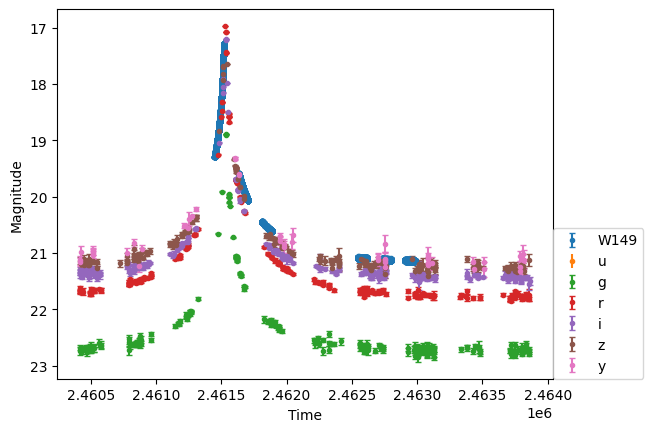

In [119]:
for telo in telescopes:
    plt.errorbar(telo.lightcurve_magnitude['time'],telo.lightcurve_magnitude['mag'],telo.lightcurve_magnitude['err_mag'],ls='',marker='.',capsize=2,label=telo.name)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc=(1,0))
plt.gca().invert_yaxis()
plt.show()

In [120]:
PAR = ['t0','u0','tE','rho','separation','mass_ratio','alpha','piEN','piEE','v_para', 'v_perp','v_radial','r_s','a_s']
ulens_params = []
for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []

# Here we change the zero point to the pyLIMA convention in order to make the alignment
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params
# true_params

In [121]:

def model_rubin_roman(Source, true_model, event_params, path_ephemerides, model, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z, lsst_y):
    '''
    Perform fit for Rubin and Roman data for fspl, usbl and pspl
    '''
    
    tlsst = 60350.38482057137 + 2400000.5
    RA, DEC = 267.92497054815516, -29.152232510353276
    e = event.Event(ra=RA, dec=DEC)

    if len(lsst_u) + len(lsst_g) + len(lsst_r) + len(lsst_i) + len(lsst_z) + len(lsst_y) == 0:
        e.name = 'Event_Roman_' + str(int(Source))
        name_roman = 'Roman (Roman)'
    else:
        e.name = 'Event_RR_' + str(int(Source))
        name_roman = 'Roman (Roman+Rubin)'
    tel_list = []

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name=name_roman, camera_filter='W149',
                                light_curve=wfirst_lc,
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Space')

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:, 0] = ephemerides[:, 0]
    ephemerides[:, 3] *= 60 * 300000 / 150000000
    deltaT = tlsst - ephemerides[:, 0][0]
    ephemerides[:, 0] = ephemerides[:, 0] + deltaT
    tel1.spacecraft_positions = {'astrometry': [], 'photometry': ephemerides}
    e.telescopes.append(tel1)
    tel_list.append('Roman')
    
    lsst_lc_list = [lsst_u, lsst_g, lsst_r, lsst_i, lsst_z, lsst_y]
    lsst_bands = "ugrizy"
    for j in range(len(lsst_lc_list)):
        if len(lsst_lc_list[j]) != 0:
            tel = telescopes.Telescope(name=lsst_bands[j]+' (Rubin)', camera_filter=lsst_bands[j],
                                       light_curve=lsst_lc_list[j],
                                       light_curve_names=['time', 'mag', 'err_mag'],
                                       light_curve_units=['JD', 'mag', 'mag'],
                                       location='Earth')
            e.telescopes.append(tel)
            tel_list.append(lsst_bands[j])
    
    e.check_event()
    
    # Use t_center if available; otherwise, use t0
    t_guess = float(event_params['t_center']) if 't_center' in event_params else float(event_params.get('t0', None))

    # Check if model is specified and create the appropriate model instance
    pyLIMAmodel = USBL_model.USBLmodel(e,
                                       blend_flux_parameter='ftotal',
                                       parallax=['Full', t_guess], orbital_motion=['Keplerian', t0])
    return pyLIMAmodel


In [122]:
model_ulens = 'USBL'

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
event_params['s']=event_params['separation']
event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)


AttributeError: 'list' object has no attribute 'Telescope'

In [ ]:

# if len(true_params) != len(model_true.model_dictionnary):
#     telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
#     telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
#                          telescopes_fluxes]#._fields]
#     model_parameters3 = np.r_[true_params, telescopes_fluxes]
# else:
#     model_parameters3 = true_params


In [ ]:
fig, axes = plt.subplots(1, 1,figsize=(8,6))

axes.set_ylabel("Magnitude",fontsize=20)
axes.set_xlabel("Time",fontsize=20)
axes.grid(True, color='0.95')
axes.invert_yaxis()
# axes.set_title('Simulated event')

pyLIMA_plots.plot_photometric_models(axes, model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes, model_true, true_params, plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

axes.legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()

In [ ]:
from bokeh.plotting import figure, show
# Create a Bokeh figure
bokeh_plot = figure(
    width=800*2, height=400*2,
    title="Microlensing Photometric Models",
    x_axis_label="Time",
    y_axis_label="Magnitude",
    tools="pan,wheel_zoom,box_zoom,reset"
)

# Call the function to plot the photometric models
pyLIMA_plots.plot_photometric_models(
    figure_axe=None,  # Pass None if you're only using Bokeh
    microlensing_model=model_true,
    model_parameters=true_params,
    bokeh_plot=bokeh_plot,
    plot_unit='Mag'
)

pyLIMA_plots.plot_aligned_data(figure_axe=None,  # Pass None if you're only using Bokeh
    microlensing_model=model_true,
    model_parameters=true_params,
    bokeh_plot=bokeh_plot,
    plot_unit='Mag'
)
bokeh_plot.y_range.flipped = True
show(bokeh_plot)

In [ ]:

figure_trajectory, bokeh_geometry = pyLIMA_plots.plot_geometry( model_true, true_params ,True)
# pyLIMA_plots.plot_geometry(usbl, fit_2.fit_results['best_model'])

In [ ]:

bokeh_geometry.title.text = "Microlensing Geometry"
bokeh_geometry.title.align = "center"
bokeh_geometry.title.text_font_size = "40px"
show(bokeh_geometry)